In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils  import to_categorical
import matplotlib.pyplot as plt 
import pickle
import numpy as np
import os
import cv2
from emnist import extract_training_samples, extract_test_samples
from sklearn.metrics import accuracy_score

In [2]:
X_train, y_train = extract_training_samples('balanced')
X_train = np.expand_dims(X_train,-1).astype(np.float32) / 255.0
print(X_train.shape)
print(y_train.shape)

#Make it compatible with CNN


(112800, 28, 28, 1)
(112800,)


In [3]:
X_test, y_test = extract_test_samples('balanced')
X_test = np.expand_dims(X_test,-1).astype(np.float32) / 255.0

In [4]:
twentypercent = int(len(X_train)*0.2)
print(twentypercent)
X_valid, X_train = X_train[:9456], X_train[9456:]
y_valid, y_train = y_train[:9456], y_train[9456:]

22560


In [5]:
X = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [6]:
n_conv1 = 64
n_hidden1 = 512
n_outputs = 47

In [7]:
with tf.name_scope("dnn"):
    conv1 = tf.layers.conv2d(X, 
                             n_conv1, 
                             kernel_size = (7,7), 
                             strides=(3,3), 
                             name="conv1", 
                             activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(conv1, 
                                    pool_size=(4,4), 
                                    strides=(4,4))
    
    flatten = tf.layers.flatten(pool1)
    
    dropout = tf.nn.dropout(flatten, rate=0.2)

    fc1 = tf.layers.dense(dropout, 
                          n_hidden1, 
                          name="fc1",
                          activation=tf.nn.relu)
    
    logits = tf.layers.dense(fc1, 
                             n_outputs, 
                             name="outputs")

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.


In [8]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [9]:
learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [10]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [11]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [12]:
n_epochs = 15
batch_size = 25

0 Batch accuracy: 0.88 Validation accuracy: 0.7989636
1 Batch accuracy: 0.92 Validation accuracy: 0.8244501
2 Batch accuracy: 0.92 Validation accuracy: 0.83608294
3 Batch accuracy: 0.84 Validation accuracy: 0.84115905
4 Batch accuracy: 0.88 Validation accuracy: 0.83936125
5 Batch accuracy: 0.88 Validation accuracy: 0.8431684
6 Batch accuracy: 0.84 Validation accuracy: 0.85057104
7 Batch accuracy: 0.96 Validation accuracy: 0.8457064
8 Batch accuracy: 0.72 Validation accuracy: 0.85141706
9 Batch accuracy: 0.92 Validation accuracy: 0.8432741
10 Batch accuracy: 0.84 Validation accuracy: 0.8489848
11 Batch accuracy: 0.8 Validation accuracy: 0.84813875
12 Batch accuracy: 0.8 Validation accuracy: 0.8479272
13 Batch accuracy: 0.92 Validation accuracy: 0.84295684
14 Batch accuracy: 0.64 Validation accuracy: 0.84094757


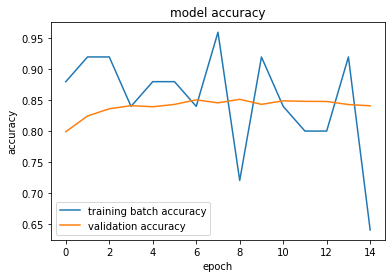

In [13]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

training_acc = []
validation_acc = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        training_acc.append(acc_batch)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        validation_acc.append(acc_valid)
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

plt.plot(training_acc)
plt.plot(validation_acc)
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training batch accuracy', 'validation accuracy'], loc='best')
plt.show()

In [14]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt") # or better, use save_path
    X_new_scaled = X_test[:100]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)
    
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test[:100])

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
Predicted classes: [41 39  9 26 44 33 14 27  3 12 16  7 35 16 16 27  6 44 28 45 29  8  4 35
 39 15 39 33 37  9 12 21 28 40 43 12 20 26 12  1 37 37 44 23  3 28 43 25
  1 14  6 31 44 21 26 17 44 28 34 35  0 39 33 16 33  2  3 44 18 36 38 26
 28 37 39 23 46 33  3 35 45 17 28 33 12 32 31 39 13 40 29 16 32 26 13  1
 12 44  5 42]
Actual classes:    [41 39  9 26 44 33 14 11  3 12 16  7  2 16 16 27  6 44 28 45 29  8  4 35
 39 40 39 33 37 16 12 21 28 40 43 12 20 26 12  1 37 37 44 23  3  5 43 25
  1 14  6 31 44 21 26 17 44 28 34 35  0 39 33 16 33  2  3 44 18 36 38 26
 28 19 39 23 40 33  3 35 45 17 28 33 12 32 31 11 13 40 29 16 32 26 13  1
 12 44  5 42]


In [17]:
print("Test Accuracy: ", accuracy_score(y_test[:100],y_pred))

Test Accuracy:  0.92
